In [1]:
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import seaborn as sn

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score,matthews_corrcoef


In [2]:
CLASSES = ["covid", "pneumonia", "regular", "uninformative"]

In [ ]:
from pocovidnet.evaluate_covid19 import Evaluator

In [47]:
def majority_vote(preds, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds = np.asarray(preds)
    gt = np.asarray(gt)
    vids = np.asarray([vid.split(".")[0] for vid in vid_filenames])
    vid_preds_out = []
    for v in np.unique(vids):
        preds_video = preds[vids==v]
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        labs, pred_counts = np.unique(preds_video, return_counts=True)
        # take label that is predicted most often
        vid_pred = labs[np.argmax(pred_counts)]
        # print("preds for video:", preds_video)
        # print(v[:3], vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    # print("video accuracy (majority):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out
        
def average_certainty(preds_logits, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds_logits = np.asarray(preds_logits)
    gt = np.asarray(gt)
    vid_preds_out = []
    vids = np.array([vid.split(".")[0] for vid in vid_filenames])
    for v in np.unique(vids):
        preds_video_logits = preds_logits[vids==v]
        preds_video = np.sum(preds_video_logits, axis=0)
        # print("preds for video:", preds_video)
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        # take label that is predicted most often
        vid_pred = np.argmax(preds_video)
        # print(v, vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    # print("video accuracy (certainty):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out

In [48]:
def mcc_multiclass(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mcc_out = []
    for classe in np.unique(y_true):
        y_true_binary = (y_true==classe).astype(int)
        y_pred_binary = (y_pred==classe).astype(int)
        mcc_out.append(matthews_corrcoef(y_true_binary, y_pred_binary))
    return mcc_out
def specificity(y_true, y_pred):
    # true negatives / negatives
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    spec_out = []
    for classe in np.unique(y_true):
        negatives = np.sum((y_true!=classe).astype(int))
        tn = np.sum((y_pred[y_true!=classe]!=classe).astype(int))
        spec_out.append(tn/negatives)
    return spec_out

## Evaluation script for cross validation

In [ ]:
saved_logits, saved_gt, saved_files = [], [], []

for i in range(5):
    print("------------- SPLIT ", i, "-------------------")
    # define data input path
    path = "../../data/cross_validation/split"+str(i)
    
    train_labels, test_labels, test_files = [], [], []
    train_data, test_data = [], []

    # loop over the image paths (train and test)
    for imagePath in paths.list_images(path):

        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        test_labels.append(label)
        test_data.append(image)
        test_files.append(imagePath.split(os.path.sep)[-1])

    # build ground truth data
    gt_class_idx = np.array([CLASSES.index(lab) for lab in test_labels])
    model = None
    # load model
    model = Evaluator(weights_dir="NasNet_F", ensemble=False, split=i, num_classes=len(CLASSES), model_id="nasnet")
    print("testing on n_files:", len(test_data))
    
    # MAIN STEP: feed through model and compute logits
    logits = np.array([model(img) for img in test_data])
    
    # remember for evaluation:
    saved_logits.append(logits)
    saved_gt.append(gt_class_idx)
    saved_files.append(test_files)
    
    # output the information
    predIdxs = np.argmax(logits, axis=1)
    
    print(
    classification_report(
        gt_class_idx, predIdxs, target_names=CLASSES
        )
    )

    vid_preds_certainty = average_certainty(logits, gt_class_idx, np.array(test_files))
    vid_preds_majority = majority_vote(predIdxs, gt_class_idx, np.array(test_files))
    print("video accuracies:", vid_preds_certainty, vid_preds_majority)

In [8]:
import pickle
with open("NASF_fold4.dat", "wb") as outfile:
    pickle.dump((logits, gt_class_idx, test_files), outfile)

### Save outputs

In [10]:
import pickle
with open("model_comparison/results_segment.dat", "wb") as outfile:
    pickle.dump((saved_logits, saved_gt, saved_files), outfile)

#### collect single folds

In [9]:
saved_logits, saved_gt, saved_files = [], [], []
for i in range(5):
    with open("NASF_fold"+str(i)+".dat", "rb") as outfile:
        (logits, gt, files) = pickle.load(outfile)
        saved_logits.append(logits)
        saved_gt.append(gt)
        saved_files.append(files)

#### Transform from uninformative class ones to general

In [174]:
new_logits, new_gt, new_files = [], [], []
counter = 0
for i in range(5):
    gt_inds = np.where(np.array(saved_gt[i])<3)[0]
    counter += len(gt_inds)
    new_logits.append(np.array(saved_logits[i])[gt_inds, :3])
    new_gt.append(np.array(saved_gt[i])[gt_inds])
    new_files.append(np.array(saved_files[i])[gt_inds])
    
import pickle
with open("../encoding_3.dat", "wb") as outfile:
    pickle.dump((new_logits, new_gt, new_files), outfile)

### Load outputs (takes the dat files that was saved from the evaluation above)

In [177]:
import pickle # 
with open("../encoding_3.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
    
CLASSES = ["covid", "pneumonia", "regular"] # , "uninformative"]

## Compute scores of our model

### Compute the reports and accuracies

In [178]:
all_reports = []
accs = []
bal_accs = []
# vid_accs, _, vid_accs_bal, _ = video_accuracy(saved_logits, saved_gt, saved_files)
for s in range(5):
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    report = classification_report(
        gt_s, pred_idx_s, target_names=CLASSES, output_dict=True
        )
    mcc_scores = mcc_multiclass(gt_s, pred_idx_s)
    spec_scores = specificity(gt_s, pred_idx_s)
    for i, cl in enumerate(CLASSES):
        report[cl]["mcc"] = mcc_scores[i]
        report[cl]["specificity"] = spec_scores[i]
    df = pd.DataFrame(report).transpose()
    df = df.drop(columns="support")
    df["accuracy"] = [report["accuracy"] for _ in range(len(df))]
    bal = balanced_accuracy_score(gt_s, pred_idx_s)
    df["balanced"] = [bal for _ in range(len(df))]
    # df["video"] = vid_accs[s]
    # df["video_balanced"] = vid_accs_bal[s]
    # print(df[:len(CLASSES)])
    # print(np.array(df)[:3,:])
    accs.append(report["accuracy"])
    bal_accs.append(balanced_accuracy_score(gt_s, pred_idx_s))
    # df = np.array(report)
    all_reports.append(np.array(df)[:len(CLASSES)])

In [179]:
df_arr = np.around(np.mean(all_reports, axis=0), 2)
df_classes = pd.DataFrame(df_arr, columns=["Precision", "Recall", "F1-score", "MCC", "Specificity", "Accuracy", "Balanced"], index=CLASSES)
df_classes

,Precision,Recall,F1-score,MCC,Specificity,Accuracy,Balanced
covid,0.91,0.92,0.91,0.82,0.90,0.9,0.89
pneumonia,0.89,0.95,0.92,0.89,0.95,0.9,0.89
regular,0.89,0.79,0.82,0.80,0.98,0.9,0.89


In [180]:
df_std = np.around(np.std(all_reports, axis=0), 2)
df_std = pd.DataFrame(df_std, columns=["Precision", "Recall", "F1-score", "MCC", "Specificity", "Accuracy", "Balanced"], index=CLASSES)
df_std


,Precision,Recall,F1-score,MCC,Specificity,Accuracy,Balanced
covid,0.06,0.09,0.03,0.04,0.06,0.03,0.05
pneumonia,0.12,0.04,0.07,0.08,0.06,0.03,0.05
regular,0.10,0.17,0.11,0.12,0.02,0.03,0.05


In [181]:
df_classes = df_classes[["Accuracy", "Balanced", "Precision", "Recall","Specificity", "F1-score", "MCC"]]
df_std = df_std[["Accuracy", "Balanced", "Precision", "Recall","Specificity", "F1-score", "MCC"]]


In [182]:
df_classes.to_csv("model_comparison/encoding_3_mean.csv")
df_std.to_csv("model_comparison/encoding_3_std.csv")

### Output accuracy

In [19]:
print("The accuracy and balanced accuracy of our model are:")
print(np.around(accs,2),np.around(bal_accs,2))
print("MEAN ACC:", round(np.mean(accs), 2), "MEAN BAL ACC:", round(np.mean(bal_accs),2))

The accuracy and balanced accuracy of our model are:
[0.66 0.79 0.78 0.86 0.79] [0.65 0.76 0.73 0.75 0.76]
MEAN ACC: 0.78 MEAN BAL ACC: 0.73


In [18]:
print("The accuracy and balanced accuracy of our model are:")
print(np.around(accs,2),np.around(bal_accs,2))
print("MEAN ACC:", round(np.mean(accs), 2), "MEAN BAL ACC:", round(np.mean(bal_accs),2))

The accuracy and balanced accuracy of our model are:
[0.82 0.92 0.93 0.98 0.81] [0.8  0.9  0.91 0.96 0.67]
MEAN ACC: 0.89 MEAN BAL ACC: 0.85


## Make table of results distinguished by classes

#### Helper functions

In [52]:
def comp_nr_videos(saved_files):
    file_list = []
    for sav in saved_files:
        file_list.extend(sav)
    assert len(np.unique(file_list)) == len(file_list)
    cutted_files = [f.split(".")[0] for f in file_list]
    print("number of videos", len(np.unique(cutted_files)))
    vid_file_labels = [v[:3].lower() for v in np.unique(cutted_files)]
    print(len(vid_file_labels))
    print(np.unique(vid_file_labels, return_counts=True))
    lab, counts = np.unique(vid_file_labels, return_counts=True)
    return counts.tolist()

def compute_specificity(all_cms):
    """
    Function to compute the specificity from confusion matrices
    all_cms: array of size 5 x 3 x 3 --> confusion matrix for each fold
    """
    specificities_fold = []
    for k in range(len(all_cms)):
        arr = all_cms[k]
        overall = np.sum(arr)
        specificity = []
        for i in range(len(arr)):
            tn_fp = overall - np.sum(arr[i])
            # print(bottom_six)
            fp = 0
            for j in range(len(arr)):
                if i!=j:
                    fp += arr[j, i]
            spec = (tn_fp-fp)/tn_fp
            # print("tn", tn_fp-fp, "tn and fp:", tn_fp)
            # print(spec)
            specificity.append(spec)
        specificities_fold.append(specificity)
    out_spec = np.mean(np.asarray(specificities_fold), axis=0)
    return np.around(out_spec, 2)

### Sum up confusion matrices

In [49]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

#### Add specificit, number of frames etc

In [50]:
np.sum(np.sum(all_cms, axis=0), axis=1)

array([693., 377., 295.])

In [54]:
df_classes["Specificity"] = np.around(compute_specificity(all_cms),2)
df_classes["Frames"] = np.sum(np.sum(all_cms, axis=0), axis=1).astype(int).tolist()
# df_classes["Videos/Images"] = comp_nr_videos(saved_files)
# df_classes = df_classes.drop(columns=["Support"])

In [104]:
df_classes.to_csv("average_scores.csv")

In [55]:
# OLD MODEL:
df_classes

,Precision,Recall,F1-score,MCC,Specificity,Accuracy,Balanced,Video Acc,Video Balanced,Frames
covid,0.75,0.89,0.81,0.62,0.71,0.78,0.73,0.8,0.76,693
pneumonia,0.93,0.78,0.84,0.80,0.98,0.78,0.73,0.8,0.76,377
regular,0.72,0.51,0.57,0.50,0.92,0.78,0.73,0.8,0.76,295


## Comparison to Covid-Net

Manually copied data from txt fil

F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [18]:
cm0 = np.array([[1, 5, 34],[0, 56., 2], [0,0,120]])
cm1 = np.array([[0., 0., 31.], [0., 44., 16.], [0., 7., 106.]])
cm2 = np.array([[0,0,22], [0,71,0], [4,0,179]])
cm3 = np.array([[0., 0., 37.], [1, 39,2], [0,0,128]])
cm4 = np.array([[0., 0., 37.], [0,35,7], [0,1, 127]])
    
# sensitivities
sens_reg = np.mean([ 0.025, 0, 0, 0,0])
sens_pneu = np.mean([0.966, 0.733, 1, 0.929, 0.833])
sens_covid = np.mean([1.0, 0.938, 0.978, 1, 0.992])
# precisions
prec_reg = np.mean([1.0, 0, 0, 0, 0])
prec_pneu = np.mean([0.918, 0.863, 1, 1.0, 0.972])
prec_covid = np.mean([0.769, 0.693, 0.891, 0.766, 0.743])

accs_covidnet = [0.8119266, 0.73529, 0.905797, 0.80676, 0.78260]

all_cms_cov_model = np.array([cm0, cm1, cm2, cm3, cm4])
print(all_cms_cov_model.shape)

(5, 3, 3)


In [19]:
def f_measure(prec, rec):
    return (2*prec*rec)/(prec+rec)

#### Output accuracy and balanced accuracy

In [20]:
added_cms_cov_net = np.sum(all_cms_cov_model, axis=0)
bal_acc_covidnet = np.diag(added_cms_cov_net)/np.sum(added_cms_cov_net, axis=1)
print("The accuracy and balanced accuracy of our model are:")
print(np.around(accs_covidnet,2),np.around(bal_acc_covidnet,2))
print("MEAN ACC:", round(np.mean(accs_covidnet), 2), "MEAN BAL ACC:", round(np.mean(bal_acc_covidnet),2))

The accuracy and balanced accuracy of our model are:
[0.81 0.74 0.91 0.81 0.78] [0.01 0.9  0.98]
MEAN ACC: 0.81 MEAN BAL ACC: 0.63


#### Make similar table for covid-net

In [21]:
sens_reg

0.005

In [24]:
df_classes["Class"] = df_classes.index
df_classes.index = ["our model", "our model","our model"]
df_cov = df_classes.copy()
df_cov.index = ["covid-net", "covid-net", "covid-net"]
df_cov["Precision"] = np.around([prec_covid, prec_pneu, prec_reg], 3).tolist()
df_cov["Recall"] = np.around([sens_covid, sens_pneu, sens_reg], 3).tolist()
sens = np.array(compute_specificity(all_cms_cov_model))[[2,1,0]]
df_cov["Specificity"] = sens.tolist()
df_cov["F1-score"] = np.around([f_measure(p, r) for (p,r) in zip([prec_covid, prec_pneu, prec_reg], [sens_covid, sens_pneu, sens_reg])], 2)

In [25]:
df_cov

,Precision,Recall,F1-score,Specificity,Frames,Videos/Images,Class
covid-net,0.772,0.982,0.86,0.57,654,39,our model
covid-net,0.951,0.892,0.92,0.98,277,14,our model
covid-net,0.200,0.005,0.01,1.00,172,11,our model


#### Merge both tables and output final table as latex

In [36]:
results_together = pd.concat([df_classes, df_cov])
results_together["Sensitivity"] = results_together["Recall"]
results_together = results_together[["Class", "Sensitivity", "Specificity", "Precision", "F1-score", "Frames", "Videos/Images"]]
print(results_together.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &      Class &  Sensitivity &  Specificity &  Precision &  F1-score &  Frames &  Videos/Images \\
\midrule
our model &      covid &         0.96 &         0.79 &       0.88 &      0.92 &     654 &             39 \\
our model &  pneunomia &         0.93 &         0.98 &       0.95 &      0.94 &     277 &             14 \\
our model &    regular &         0.55 &         0.98 &       0.78 &      0.62 &     172 &             11 \\
covid-net &      covid &         0.98 &         0.57 &       0.77 &      0.86 &     654 &             39 \\
covid-net &  pneunomia &         0.89 &         0.98 &       0.95 &      0.92 &     277 &             14 \\
covid-net &    regular &         0.00 &         1.00 &       0.20 &      0.00 &     172 &             11 \\
\bottomrule
\end{tabular}



In [35]:
results_together

,Class,Sensitivity,Specificity,Precision,F1-score,Frames,Videos/Images
our model,covid,0.82,0.87,0.87,0.84,371,20
our model,pneunomia,0.93,0.98,0.92,0.92,122,11
our model,regular,0.80,0.90,0.75,0.77,158,14
covid-net,covid,0.88,0.76,0.84,0.86,371,20
covid-net,pneunomia,0.95,0.96,0.87,0.91,122,11
covid-net,regular,0.54,0.92,0.60,0.57,158,14


## Compute video accuracy

In [54]:
def video_accuracy(saved_logits, saved_gt, saved_files):
    def preds_to_score(vid_preds_out):
        return accuracy_score([p[2] for p in vid_preds_out], [p[1] for p in vid_preds_out])

    def preds_to_balanced(vid_preds_out):
        # print([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out])
        return balanced_accuracy_score([p[2] for p in vid_preds_out], [p[1] for p in vid_preds_out])

    scores_certainty, score_cert_bal = [], []
    scores_majority, score_maj_bal = [], []
    for i in range(len(saved_files)):
        # print("-----------", i, "---------")
        filenames = np.array(saved_files[i])
        only_videos = np.where(np.array([len(name.split("."))==3 for name in filenames]))[0]
        # print(len(only_videos), len(filenames))
        logits_in = np.array(saved_logits[i])[only_videos]
        files_in = filenames[only_videos]
        gt_in = np.array(saved_gt[i])[only_videos]

        vid_preds_certainty = average_certainty(logits_in, gt_in, files_in)
        vid_preds_majority = majority_vote(np.argmax(logits_in, axis=1), gt_in, files_in)
        scores_certainty.append(preds_to_score(vid_preds_certainty))
        scores_majority.append(preds_to_score(vid_preds_majority))
        score_maj_bal.append(preds_to_balanced(vid_preds_majority))
        score_cert_bal.append(preds_to_balanced(vid_preds_certainty))
    # print("certainty:", scores_certainty)
    # print("majority:", scores_majority)
    return scores_certainty, scores_majority, score_maj_bal, score_cert_bal

In [111]:
scores_certainty, scores_majority, score_maj_bal, score_cert_bal = video_accuracy(saved_logits, saved_gt, saved_files)
scores_certainty, scores_majority

([1.0, 0.8333333333333334, 0.9, 0.9444444444444444, 0.875],
 [1.0, 0.8333333333333334, 0.9, 0.9444444444444444, 0.9375])

In [28]:
score_maj_bal, score_cert_bal

([0.7999999999999999,
  0.9333333333333332,
  0.8888888888888888,
  0.8777777777777779,
  0.6205128205128205],
 [0.7999999999999999,
  0.9333333333333332,
  0.8888888888888888,
  0.8777777777777779,
  0.6205128205128205])

In [112]:
print("RESULTS VIDEO ACCURACY:")
print("Accuracies: ", scores_certainty, "MEAN:", round(np.mean(scores_certainty), 3))
print("Balanced accs:", score_cert_bal, "MEAN:", round(np.mean(score_cert_bal),3))

RESULTS VIDEO ACCURACY:
Accuracies:  [1.0, 0.8333333333333334, 0.9, 0.9444444444444444, 0.875] MEAN: 0.911
Balanced accs: [1.0, 0.8727272727272727, 0.9333333333333332, 0.9166666666666666, 0.8412698412698413] MEAN: 0.913


In [107]:
print("RESULTS VIDEO ACCURACY:")
print("Accuracies: ", scores_certainty, "MEAN:", round(np.mean(scores_certainty), 3))
print("Balanced accs:", score_cert_bal, "MEAN:", round(np.mean(score_cert_bal),3))

RESULTS VIDEO ACCURACY:
Accuracies:  [1.0, 0.8260869565217391, 0.9, 0.7878787878787878, 0.7083333333333334] MEAN: 0.844
Balanced accs: [1.0, 0.8727272727272727, 0.9333333333333332, 0.7826797385620915, 0.7222222222222222] MEAN: 0.862


In [113]:
print("number of images in each split")
for file_list in saved_files:
    cutted_files = [files.split(".")[0] for files in file_list]
    # print(np.unique(cutted_files))
    image_number = [len(files.split("."))!=3 for files in file_list]
    print(np.sum(image_number))

number of images in each split
0
5
0
15
8


## Confusion matrix plots

#### Load the results

In [3]:
with open("cross_val_cam_3.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)

#### Sum up confusion matrices

In [4]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

#### Function to make labels with std from the data

In [5]:
def data_to_label(data, text):
    return (np.asarray(["{0:.2f}\n".format(data)+u"\u00B1"+"{0:.2f}".format(text) for data, text in zip(data.flatten(), text.flatten())])).reshape(3,3)

#### Make figure

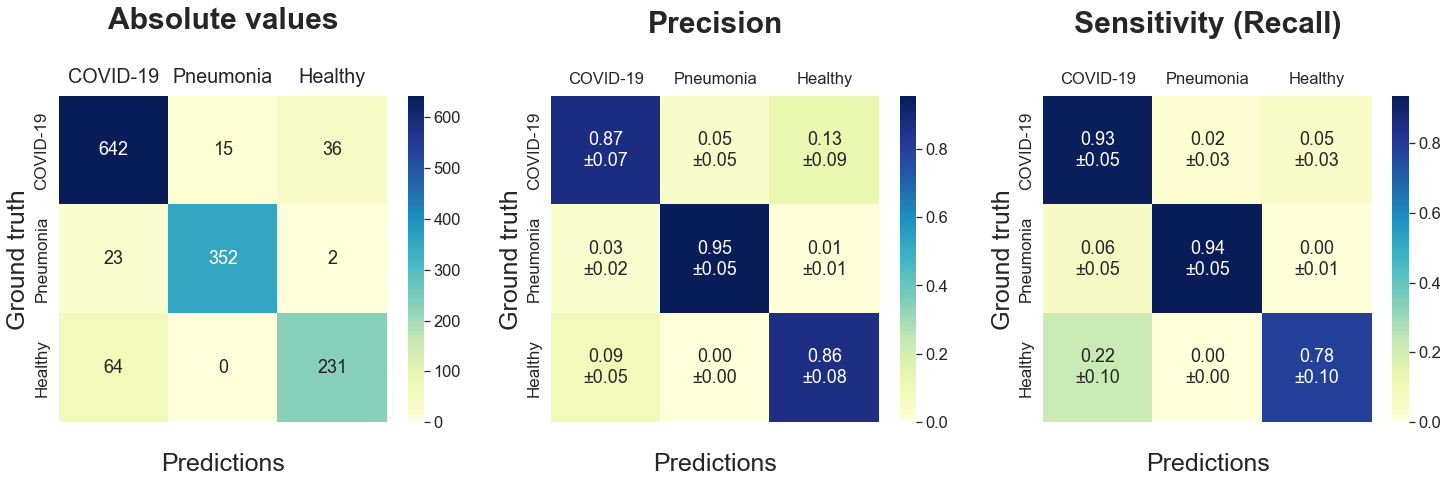

In [20]:
plt.figure(figsize = (25,6))
fig = plt.subplot(1,3,1)
ax = fig.axes

data_abs = np.sum(all_cms, axis=0)
df_cm = pd.DataFrame(data_abs, index = [i for i in ["COVID-19", "Pneumonia", "Healthy"]],
                  columns = [i for i in ["COVID-19", "Pneumonia", "Healthy"]])

sn.set(font_scale=1.5)

# plt.xticks(np.arange(3)+0.5,("COVID-19", "Pneumonia", "Normal"), rotation=0, fontsize="17", va="center")
plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneumonia", "Healthy"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=True, fmt="g", cmap="YlGnBu")
ax.xaxis.tick_top()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Absolute values\n", size=30,fontweight="bold")


# PRECISION SUBPLOT
fig = plt.subplot(1,3,2)
ax = fig.axes


data_prec = all_cms.copy()
for i in range(5):
    data_prec[i] = data_prec[i]/np.sum(data_prec[i], axis=0)
prec_stds = np.std(data_prec, axis = 0)
data_prec = np.mean(data_prec, axis=0)
labels_prec = data_to_label(data_prec, prec_stds)

df_cm = pd.DataFrame(data_prec, index = [i for i in ["COVID-19", "Pneumonia", "Healthy"]],
                  columns = [i for i in ["COVID-19", "Pneumonia", "Healthy"]])
sn.set(font_scale=1.5)
ax.xaxis.tick_top()
plt.ylabel("ground truth")
plt.xlabel("predictions")
plt.title("Precision")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneumonia", "Healthy"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=labels_prec, fmt='', cmap="YlGnBu")
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Precision\n", size=30,fontweight="bold")

plt.savefig("confusion_matrix_newdata.pdf",bbox_inches='tight') #, bottom=0.2)


#  SENSITIVITY SUBPLOT
fig = plt.subplot(1,3,3)
ax = fig.axes
data_sens = all_cms.copy()
for i in range(5):
    sums_axis = np.sum(data_sens[i], axis=1)
    data_sens[i] = np.array([data_sens[i,j,:]/sums_axis[j] for j in range(3)])
sens_stds = np.std(data_sens, axis = 0)
data_sens = np.mean(data_sens, axis=0)

labels_sens = data_to_label(data_sens, sens_stds)
df_cm = pd.DataFrame(data_sens, index = [i for i in ["COVID-19", "Pneumonia", "Healthy"]],
                  columns = [i for i in ["COVID-19", "Pneumonia", "Healthy"]])
# sn.set(font_scale=1.5)

plt.yticks(np.arange(3)+0.5,("COVID-19", "Pneumonia", "Healthy"), rotation=0, fontsize="17", va="center")
#plt.xticks(np.arange(3)+0.5,("COVID-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
ax.xaxis.tick_top()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 

sn.heatmap(df_cm, annot=labels_sens, fmt='', cmap="YlGnBu")
plt.xlabel('\nPredictions', size=25)
plt.ylabel('Ground truth', size=25)
plt.title("Sensitivity (Recall)\n", size=30,fontweight="bold")

plt.savefig("confusion_matrix_all.pdf",bbox_inches='tight') #, bottom=0.2)



## ROC AUC

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score

### Compute scores and curve

In [8]:
base_eval_points = np.linspace(0,1,200,endpoint=True)
        
def roc_auc(saved_logits, saved_gt):
    data, scores, roc_auc_std = [], [], []
    max_points = []
    for i in range(3):
        out_roc = np.zeros((5, len(base_fpr)))
        out_prec = np.zeros((5, len(base_rec)))

        roc_auc = []
        max_acc = []
        
        # Iterate over folds
        for k in range(5):
            # get binary predictions for this class
            gt =  (saved_gt[k] == i).astype(int)
            # pred = saved_logits[k][:, i]
            if np.any(saved_logits[k]<0):
                pred = np.exp(np.array(saved_logits[k]))[:, i]
            else:
                pred = np.array(saved_logits[k])[:, i]
            
            roc_auc.append(roc_auc_score(gt, pred))
            
            precs, recs, fprs, julie_points = [], [], [], []
            for j, thresh in enumerate(np.linspace(0,1.1,100, endpoint=True)):
                preds_thresholded = (pred>thresh).astype(int)
                tp = np.sum(preds_thresholded[gt==1])
                p = np.sum(gt)
                n = len(gt)-p
                fp = np.sum(preds_thresholded[gt==0])
                inverted = np.absolute(preds_thresholded - 1)
                tn = np.sum(inverted[gt==0])
                fn = np.sum(inverted[gt==1])
                fpr = fp/float(n)
                tpr = tp/float(p)
                
                if tp+fp ==0:
                    precs.append(1)
                else:
                    precs.append(tp/(tp+fp))
                recs.append(tpr)
                fprs.append(fpr)
                julie_points.append((tp+tn)/(tp+tn+fp+fn))

            # clean
            recs = np.asarray(recs)
            precs = np.asarray(precs)
            fprs = np.asarray(fprs)
            sorted_inds = np.argsort(recs)
            # prepare for precision-recall curve
            precs_sorted = precs[sorted_inds]
            recs_sorted = recs[sorted_inds]
            precs_cleaned = precs_sorted[recs_sorted>0]
            recs_cleaned = recs_sorted[recs_sorted>0]
            precs_inter = np.interp(base_eval_points, recs_cleaned, precs_cleaned)
            # prepare for roc-auc curve
            sorted_inds = np.argsort(fprs)
            recs_fpr_sorted = recs[sorted_inds]
            fprs_sorted = fprs[sorted_inds]
            roc_inter = np.interp(base_eval_points, fprs_sorted, recs_fpr_sorted)
            # append current fold
            out_prec[k] = precs_inter
            out_roc[k] = roc_inter
            
            # compute recall of max acc:
            max_acc.append(recs[np.argmax(julie_points)])

        # out_curve = np.mean(np.asarray(out_curve), axis=0)

        prec_mean = np.mean(out_prec, axis=0)
        prec_std = np.std(out_prec, axis=0)
        roc_mean = np.mean(out_roc, axis=0)
        roc_std = np.std(out_roc, axis=0)
        
        # append scores
        scores.append(round(np.mean(roc_auc),2))
        roc_auc_std.append(round(np.std(roc_auc),2))
        
        # point of maximum accuracy
        max_points.append(np.mean(max_acc))
        
        data.append((roc_mean, roc_std, prec_mean, prec_std))
    return data, max_points, scores, roc_auc_std

def closest(in_list, point):
    return np.argmin(np.absolute(np.asarray(in_list)-point))

In [9]:
from matplotlib import rc
plt.rcParams['legend.title_fontsize'] = 20

# plt.rcParams['axes.facecolor'] = 'white'
# activate latex text rendering
rc('text', usetex=False)

### Load data

In [10]:
with open("cross_val_cam_3.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
data, max_points, scores, roc_auc_std = roc_auc(saved_logits, saved_gt)

In [12]:
cols = ["red", "orange", "green"]
classes = ["COVID-19", "Pneumonia", "Healthy"]

#### ROC class comparison

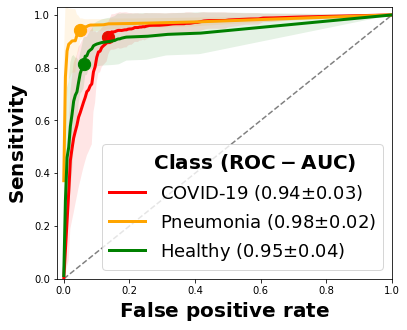

In [67]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
for i in range(3):
    roc_mean, roc_std, _, _ = data[i]
    lab = classes[i]+" (%.2f"%scores[i]+"$\pm$"+str(roc_auc_std[i])+")"
    plt.plot(base_eval_points, roc_mean, 'k-', c=cols[i], label=lab, lw=3)
    # print(len(r), max_points[i])
    # print(base_eval_points[closest(roc_mean, max_points[i])], max_points[i])
    plt.scatter(base_eval_points[closest(roc_mean, max_points[i])], max_points[i], s=150, marker="o", c=cols[i])
    plt.fill_between(base_eval_points, roc_mean-roc_std, roc_mean+roc_std, alpha=0.1, facecolor=cols[i])
    plt.ylim(0,1.03)
plt.xlim(-0.02,1)
plt.ylabel("$\\bf{Sensitivity}$", fontsize=20)
plt.xlabel("$\\bf{False\ positive\ rate}$", fontsize=20)
plt.legend(fontsize=18, title="    $\\bf{Class}\ \\bf(ROC-AUC)}$") # "\n  $\\bf{(o:\ maximal\ accuracy)}$")
# plt.title("$\\bf{ROC\ curves}$", fontsize=15)
plt.savefig("new_plots/roc_curves_cam.pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

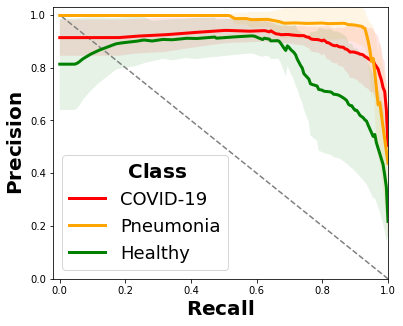

In [14]:
plt.figure(figsize=(6,5))
plt.plot([1, 0], [0, 1], color='grey', lw=1.5, linestyle='--')
for i in range(3):
    _, _, prec_mean, prec_std = data[i]
    # prec_cleaned = prec[rec>0]
    # rec_cleaned = rec[rec>0]
    # s2_cleaned = s2[rec>0]
    lab = classes[i] # +" (%.2f"%scores[i]+"$\pm$"+str(roc_auc_std[i])+")"
    plt.plot(base_eval_points, prec_mean, 'k-', c=cols[i], label=lab, lw=3)
    plt.fill_between(base_eval_points, prec_mean-prec_std, prec_mean+prec_std, alpha=0.1, facecolor=cols[i])
plt.ylim(0,1.03)
plt.xlim(-0.02,1)
plt.ylabel("$\\bf{Precision}$", fontsize=20)
plt.xlabel("$\\bf{Recall}$", fontsize=20)
plt.legend(fontsize=18, title="    $\\bf{Class}$") # "\n  $\\bf{(o:\ maximal\ accuracy)}$")
# plt.title("$\\bf{ROC\ curves}$", fontsize=15)
plt.savefig("new_plots/prec_rec_curves_cam.pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [8]:
from matplotlib import rc
plt.rcParams['legend.title_fontsize'] = 15

## ROC-curve across models

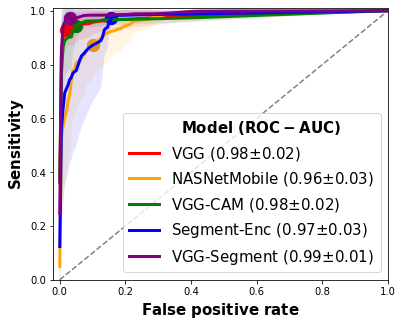

In [54]:
CLASS = 1
name_dict = {"cross_val_gradcam_3":"VGG","cross_val_cam_3":"VGG-CAM", "NAS_B_3":"NASNetMobile","encoding_3":"Segment-Enc", "results_segment_3":"VGG-Segment"}
cols = ["red", "orange", "green", "blue", "purple"]
classes = ["COVID-19", "Pneumonia", "Healthy"]
# roc_auc_scores = np.mean(np.asarray(scores), axis=0)
fig = plt.figure(figsize=(6,5))
# plt.subplot(1,3,1)
plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')
for i, model_data in enumerate(["cross_val_gradcam_3.dat", "NAS_B_3.dat", "cross_val_cam_3.dat", "encoding_3.dat", "results_segment_3.dat"]):
    with open(model_data, "rb") as outfile:
        (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
    data, max_points, scores, roc_auc_std = roc_auc(saved_logits, saved_gt)
    roc_mean, roc_std, _, _ = data[CLASS]
    lab = name_dict[model_data.split(".")[0]]+" (%.2f"%scores[CLASS]+"$\pm$"+str(roc_auc_std[CLASS])+")"
    
    plt.plot(base_eval_points, roc_mean, 'k-', c=cols[i], label=lab, lw=3)
    plt.scatter(base_eval_points[closest(roc_mean, max_points[CLASS])], max_points[CLASS], s=150, marker="o", c=cols[i])
    plt.fill_between(base_eval_points, roc_mean-roc_std, roc_mean+roc_std, alpha=0.1, facecolor=cols[i])
    # plt.ylim(0,1.03)
    # 
    # # roc auc plotting
    # fp, prec, rec, s, s2 = data[CLASS]
    # lab = name_dict[model_data.split(".")[0]]+" (%.2f"%scores[CLASS]+"$\pm$"+str(roc_auc_std[CLASS])+")"
    # plt.plot(fp, rec, 'k-', c=cols[i], label=lab, lw=3)
    # # print(len(r), max_points[i])
    # plt.scatter(fp[max_points[CLASS]], rec[max_points[CLASS]], s=150, marker="o", c=cols[i])
    # plt.fill_between(fp, rec-s, rec+s, alpha=0.1, facecolor=cols[i])
plt.ylim(0,1.01)
plt.xlim(-0.02,1)
plt.ylabel("$\\bf{Sensitivity}$", fontsize=15)
plt.xlabel("$\\bf{False\ positive\ rate}$", fontsize=15)
plt.legend(fontsize=15, title="    $\\bf{Model}\ \\bf(ROC-AUC)}$") # "\n  $\\bf{(o:\ maximal\ accuracy)}$")
# plt.title("ROC-curve (COVID-19)", fontsize=20)
plt.savefig("new_plots/roc_curve"+str(CLASS)+".pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

## Precision-recall-curve across models

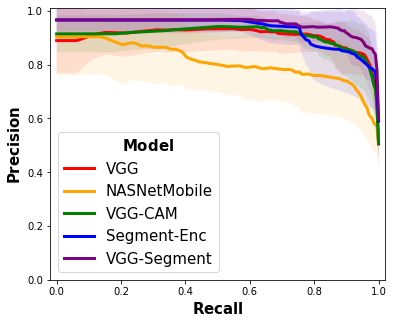

In [60]:
CLASS = 0
fig = plt.figure(figsize=(6,5))

for i, model_data in enumerate(["cross_val_gradcam_3.dat", "NAS_B_3.dat", "cross_val_cam_3.dat", "encoding_3.dat", "results_segment_3.dat"]):
    with open(model_data, "rb") as outfile:
        (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
    data, max_points, scores, roc_auc_std = roc_auc(saved_logits, saved_gt)
    _, _, prec_mean, prec_std = data[CLASS]
    lab = name_dict[model_data.split(".")[0]]
    plt.plot(base_eval_points, prec_mean, 'k-', c=cols[i], label=lab, lw=3)
    plt.fill_between(base_eval_points, prec_mean-prec_std, prec_mean+prec_std, alpha=0.1, facecolor=cols[i])
    
    # data, max_points, scores, roc_auc_std = roc_auc(saved_logits, saved_gt)
    # # roc auc plotting
    # fp, prec, rec, s, s2 = data[CLASS]
    # prec_clean = np.asarray(prec)
    # rec_clean = np.asarray(rec)
    # prec_clean = prec_clean[rec_clean>0]
    # s2_clean = np.asarray(s2)[rec_clean>0]
    # rec_clean = rec_clean[rec_clean>0]
    # lab = name_dict[model_data.split(".")[0]] # +" (%.2f"%scores[0]+"$\pm$"+str(roc_auc_std[0])+")"
    # plt.plot(rec_clean, prec_clean, 'k-', c=cols[i], label=lab, lw=3)
    # # plt.plot(rec_cheat, prec_cheat, 'k-', c=cols[i], label=lab, lw=3)
    # # print(len(r), max_points[i])
    # # plt.scatter(prec[max_points[0]], rec[max_points[0]], s=150, marker="o", c=cols[i])
    # plt.fill_between(rec, prec-s2, prec+s2, alpha=0.1, facecolor=cols[i])

plt.ylim(0,1.01)
plt.xlim(-0.02,1.02)
plt.ylabel("$\\bf{Precision}$", fontsize=15)
plt.xlabel("$\\bf{Recall}$", fontsize=15)
plt.legend(fontsize=15, title="    $\\bf{Model}}$") # "\n  $\\bf{(o:\ maximal\ accuracy)}$")
# plt.title("Precision-Recall-curve (Healthy)", fontsize=20)

plt.savefig("new_plots/prec_rec_"+str(CLASS)+".pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

### Confusion matrix

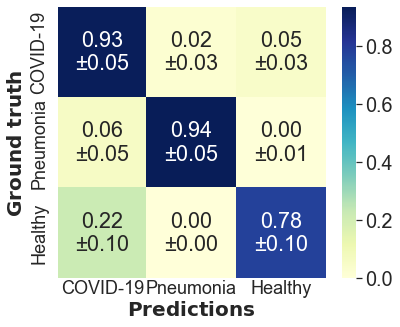

In [19]:
fig = plt.figure(figsize=(6,5))
ax = fig.axes

# ABSOLUTE
# data_confusion = np.sum(all_cms, axis=0)

# PRECISION
# data_confusion = all_cms.copy()
# for i in range(5):
#     data_confusion[i] = data_confusion[i]/np.sum(data_confusion[i], axis=0)
# prec_stds = np.std(data_confusion, axis = 0)
# data_confusion = np.mean(data_confusion, axis=0)
# labels = data_to_label(data_confusion, prec_stds)

# SENSITIVITY
data_confusion = all_cms.copy()
for i in range(5):
    sums_axis = np.sum(data_confusion[i], axis=1)
    data_confusion[i] = np.array([data_confusion[i,j,:]/sums_axis[j] for j in range(3)])
sens_stds = np.std(data_confusion, axis = 0)
data_confusion = np.mean(data_confusion, axis=0)

labels = data_to_label(data_confusion, sens_stds)

# ACTUAL PLOT

df_cm = pd.DataFrame(data_confusion, index = [i for i in ["COVID-19", "Pneumonia", "Healthy"]],
                  columns = [i for i in ["COVID-19", "Pneumonia", "Healthy"]])

sn.set(font_scale=1.8)

plt.xticks(np.arange(3)+0.5,("COVID-19", "Pneumonia", "Normal"), fontsize="18", va="center")
plt.yticks(np.arange(3)+0.5,("C", "P", "H"), rotation=0, fontsize="18", va="center")
# sn.heatmap(df_cm, annot=True, fmt="g", cmap="YlGnBu")
sn.heatmap(df_cm, annot=labels, fmt='', cmap="YlGnBu")
# ax.xaxis.tick_bottom()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)
plt.xlabel("$\\bf{Predictions}$", fontsize=20)
plt.ylabel("$\\bf{Ground\ truth}$", fontsize=20)
# plt.title("Confusion matrix (VGG2)", fontsize=20) # "Absolute values\n", size=30,fontweight="bold")

plt.savefig("new_plots/conf_matrix_cam_sens.pdf", bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

### Compute roc-auc score

In [191]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [44]:
for i in range(3):
    roc_auc = []
    for j in range(5):
        # roc auc score
        preds = saved_logits[j][:, i]
        gt = (saved_gt[j] == i).astype(int)
        # print(preds, gt)
        roc_auc.append(roc_auc_score(gt, preds))
    print(roc_auc)

[0.892032967032967, 0.973656549730653, 0.9834574417947026, 0.9990873599351012, 0.7984615384615384]
[0.9892034892034892, 0.9997367728349567, 0.9484573502722323, 0.9970982142857143, 0.8903361344537815]
[0.8470566660553823, 0.9701415701415701, 0.9848677248677248, 0.9994854076306696, 0.9768707482993197]


##  Save predictions in csv (from logits)

In [74]:
import pickle
with open("cross_val_gradcam_4.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
    
CLASSES = ["covid", "pneumonia", "regular", "uninformative"]

In [76]:
dfs = []
for i in range(5):
    df = pd.DataFrame()
    df["fold"] = [i for _ in range(len(saved_gt[i]))]
    df["filename"] = saved_files[i]
    df["ground_truth"] = saved_gt[i]
    df["prediction"] = np.argmax(saved_logits[i], axis=1)
    df["probability"] = np.max(saved_logits[i], axis=1)
    dfs.append(df)
    
together = pd.concat(dfs)
print(together.head())
print("number of files", len(together))
print("Accuracy for all predictions", np.sum(together["ground_truth"].values == together["prediction"].values)/len(together))
relevant_classes = together[together["ground_truth"]<3]
print(len(relevant_classes))
print("Accuracy for covid pneu relular predictions", np.sum(relevant_classes["ground_truth"].values == relevant_classes["prediction"].values)/len(relevant_classes))

# SAVE
together.to_csv("predictions_vgg_4.csv", index=False)
relevant_classes.to_csv("predictions_vgg_3.csv")

   fold                              filename  ground_truth  prediction  \
0     0  Pneu-Atlas-pneumonia.gif_frame18.jpg             1           1   
1     0  Pneu-Atlas-pneumonia.gif_frame24.jpg             1           1   
2     0  Pneu-Atlas-pneumonia.gif_frame30.jpg             1           1   
3     0         pneu-everyday.gif_frame45.jpg             1           1   
4     0         pneu-everyday.gif_frame51.jpg             1           1   

   probability  
0    -0.000012  
1    -0.000022  
2    -0.000303  
3    -0.052166  
4    -0.401968  
number of files 1765
Accuracy for all predictions 0.9172804532577904
1365
Accuracy for covid pneu relular predictions 0.8967032967032967


## Save predictions in csv files:

In [ ]:
dfs = []
path_to_csv = "/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/pocovidnet/models/"

for filein in os.listdir(path_to_csv):
    if filein[-3:]=="csv":
        dfs.append(pd.read_csv(path_to_csv+filein))
one_df = pd.concat(dfs)

In [ ]:
vid_name, frame_num, labels = [],[], []
label_dict = {"pne":1, "Pne":1, "Cov":0, "Reg":2}
for fn in one_df["Unnamed: 0"]:
    parts = fn.split(".")
    vid_name.append(parts[0])
    labels.append(label_dict[parts[0][:3]])
    if len(parts)==2:
        frame_num.append(None)
    elif len(parts)==3:
        frame_num.append(int(parts[1][9:]))

In [ ]:
classes = ["covid (0)", "pneumonia (1)", "healthy (2)"]
trans_df = pd.DataFrame()
trans_df["video"] = vid_name
trans_df["frame"] = frame_num
trans_df["label (0:cov, 1:pneu, 2:reg)"] = labels # [classes[l] for l in labels]
# add predictions
preds = np.array(one_df[["0","1","2"]])
sorted_preds = np.argsort(preds, axis=1)
trans_df["prediction (0:cov, 1:pneu, 2:reg)"] = sorted_preds[:,2] # [classes[l] for l in sorted_preds[:,2]]
trans_df["second_pred"] = sorted_preds[:,1]
trans_df["prob"] = np.max(preds, axis=1)
trans_df = trans_df.sort_values(by=["video", "frame"])

In [ ]:
grouped = trans_df.groupby('video').agg({"prob":"mean", "label (0:cov, 1:pneu, 2:reg)":"first"})
grouped["preds"] = list(trans_df.groupby('video')["prediction (0:cov, 1:pneu, 2:reg)"].apply(list))
def most_frequent(List): 
    return max(set(List), key = List.count)
grouped["majority_vote"] = [most_frequent(val) for val in grouped["preds"].values]
gt_vid, preds_vid = (grouped["label (0:cov, 1:pneu, 2:reg)"].values, grouped["majority_vote"].values)
gt, preds = (trans_df["label (0:cov, 1:pneu, 2:reg)"].values, trans_df["prediction (0:cov, 1:pneu, 2:reg)"].values)
print("frame accuracy:", np.sum(gt==preds)/len(gt), "video accuracy", np.sum(gt_vid==preds_vid)/len(gt_vid))

In [ ]:
grouped.to_csv("predictions.csv")
trans_df.to_csv("framewise_predictions.csv")

## Old Covid-Net results

In [ ]:
cm0 = np.array([[24., 12., 12.], [ 0., 28.,  0.], [29.,  4., 30.]])
cm1 = np.array([[  0.,   1.,  48.],[  0.,  22.,   0.],[  0.,   2., 109.]])
cm2 = np.array([[17., 5., 13.],[ 2., 24., 0.],[ 0.,  0, 94.]])
cm3 = np.array([[30., 0., 0.],[ 0., 25.,  0.],[ 3., 0, 85.]])
cm4 = np.array([[19., 0., 8.],[ 6., 25., 0.], [ 0.,  0., 80.]])

# sensitivities
sens_reg = np.mean([0.5, 0, 0.486, 1.0, 0.704])
sens_pneu = np.mean([1.0, 1.0, 0.923, 1.0, 0.806])
sens_covid = np.mean([0.476, 0.982, 1.0, 0.966, 1.0])
# precisions
prec_reg = np.mean([0.453, 0, 0.895, 0.909, 0.76])
prec_pneu = np.mean([0.636, 0.88, 0.828, 1.0, 1.0])
prec_covid = np.mean([0.714, 0.694, 0.879, 1.0, 0.909])

accs_covidnet = [0.58992805, 0.719, 0.871, 0.979, 0.89855]

all_cms_cov_model = np.array([cm0, cm1, cm2, cm3, cm4])
print(all_cms_cov_model.shape)

## Convert to latex tables

In [ ]:
base_dir = "model_comparison"
class_map2 = {0:"COVID-19", 1:"Pneumonia", 2: "Healthy",3:"Uninformative"}
for model in ["encoding_4"]: # , "cam_4", "NAS_B_4"]: # ["vid_cam_3", "genesis_3"]: # 
    mean_table = pd.read_csv(os.path.join(base_dir, model+"_mean.csv"))
    std_table = pd.read_csv(os.path.join(base_dir, model+"_std.csv"))
    print("----------", model)
    print(std_table)
    for i, row in mean_table.iterrows():
        std_row = std_table.loc[i] # std_table[std_table["Unnamed: 0"]=="covid"]
        # if i==1:
            # "& $", row["Accuracy"],"\\pm",std_row["Accuracy"],"$ &", 
        if i ==0:
            print(row["Accuracy"], std_row["Accuracy"], row["Balanced"], std_row["Balanced"])
        print("&", class_map2[i],
              "& $", row["Recall"], "\\pm {\scriptstyle",std_row["Recall"],
              "}$ & $", row["Precision"], "\\pm {\scriptstyle",std_row["Precision"],
              "}$ & $", row["F1-score"], "\\pm {\scriptstyle",std_row["F1-score"], 
              "}$ & $", row["Specificity"], "\\pm {\scriptstyle",std_row["Specificity"],
              "}$ & $",row["MCC"], "\\pm {\scriptstyle",std_row["MCC"], "} $ \\\\")
        
        # WO standard deviation
        # print("& row["Accuracy"],"&", class_map2[i],"&", row["Recall"], 
         #         "&", row["Precision"], "&", row["F1-score"], "&", row["Specificity"], "&", row["MCC"], "\\\\")
        

In [317]:
base_dir = "model_comparison"
class_map2 = {0:"COVID-19", 1:"Pneumonia", 2: "Healthy"}
for model in ["frame_based_video_evaluation", "vid_based_video_evaluation"]:
    mean_table = pd.read_csv(os.path.join(base_dir, model+".csv"))
    print("----------", model)
    for i, row in mean_table.iterrows():
        std_row = std_table.loc[i] # std_table[std_table["Unnamed: 0"]=="covid"]
        # if i==1:
            # "& $", row["Accuracy"],"\\pm",std_row["Accuracy"],"$ &", 
        print(row["Accuracy"], row["Balanced"])
        
        # WO standard deviation
        print("&", class_map2[i],"&", row["recall"], 
                "&", row["precision"], "&", row["f1-score"], "&", row["Specificity"], "&", row["MCC"], "\\\\")
        

---------- frame_based_video_evaluation
0.95 0.93
& COVID-19 & 0.97 & 0.92 & 0.95 & 0.92 & 0.9 \\
0.95 0.93
& Pneumonia & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 \\
0.95 0.93
& Healthy & 0.82 & 0.93 & 0.87 & 0.98 & 0.84 \\
---------- vid_based_video_evaluation
0.87 0.88
& COVID-19 & 0.81 & 0.91 & 0.85 & 0.92 & 0.74 \\
0.87 0.88
& Pneumonia & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 \\
0.87 0.88
& Healthy & 0.82 & 0.67 & 0.74 & 0.88 & 0.66 \\
